In [152]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2

In [153]:
# action sets to define the actions: UP, UP-RIGHT, RIGHT, DOWN_RIGHT, 
# DOWN, DOWN_LEFT, LEFT, UP_LEFT
        
def take_action(cur_state,l, i):
    status = False
    x = cur_state[0] + l*math.cos(math.radians(cur_state[2]+(i*30)))
    y = cur_state[1] + l*math.sin(math.radians(cur_state[2]+(i*30)))
    if (y <= 250 and y>=0 and x>=0 and  x<= 400):
        new_node = [x, y, int(cur_state[2]+(i*30))]
        n = new_node.copy()
#         for i in range(2):
#             x = n[i]%(math.floor(n[i]))
#             if(x<0.25):
#                 n[i] = math.floor(n[i])
#             elif(x > 0.75):
#                 n[i] = math.floor(n[i]) + 1
#             else:
#                 n[i] = math.floor(n[i])+0.5
        if n[2]<0:
            n[2] = (360 + n[2])
        elif n[2]>360:
            n[2] = (n[2]-360)
        else:
            n[2] = n[2]
        status = True
    else:
        n  = [0,0,0]
    return status, n


In [154]:
def euclidean_dist(p1,p2):
    point1 = [p1[0],p1[1]]
    point2 = [p2[0],p2[1]]
    return round(math.dist(point1,point2),2)

In [155]:
# function to check if the goal has reached
def check_goal(g, node):
    n = node.copy()
    d = euclidean_dist(g,n)
#     if n[2]<0:
#         n[2] = (360 + n[2])
#     elif n[2]>360:
#         n[2] = (n[2]-360)
#     else:
#         n[2] = n[2]
    t = abs(g[2] - n[2])
    return(d<=1.5 and t<=30)

In [156]:
#function to check if the child node is in obstacle space or not
def check_obstacle(node,c,r):
    a = math.sqrt(3)
    x = node[0]
    y = node[1]
    flag1 = False
    flag2 = False
    flag3 = False
    flag4 = False
        # Polygon space with clearance of 5
    if (x>=36-c-r and x<=115+c+r and y>=100-c-r and y<= 210+c+r ):
        if((y - (6/7)*x >= 780/7-c-r) or (y + (16/5)*x <= 2180/5+c+r)):
            if((y + (85/69)*x >= 15825/69-c-r) and (y -(25/79)*x <=13320/79+c+r)):
                flag1 = True

    # Circle with clearance of 5
    if((x-300)**2 + (y-185)**2 <= pow((40+c+r), 2)):
        flag2 = True

    # Hexagon with clearance of 5
    if ( x >= 165-c-r and x <= 235+c+r and y>= (100 - 70/a)-c-r and y<= (100 + 70/a)+c+r):
        if ((y + (2021/3500)*x >= 61273/350 -c-r) and (y - (2021/3500)*x >= -19567/350 - c-r)):
            if ((y + (101/175)*x <= 179087/700 +c+r) and (y - (101/175)*x <= 17487/700 + c+r)):
                flag3 = True

    # padding of 5 on both x and y
    if(((x>=0) and (x<=5)) or ((x>=395) and (x<=400)) and ((y>=0) and (y<=5)) or ((y>=245) and (y<=250))):
        flag4 = True
    
    return (flag1 or flag2 or flag3 or flag4)

In [157]:
#function to check if the child node is in visited or not
def check_visited(node, v_array):
    n = node.copy()
    for i in range(2):
        
        x = n[i]%(math.floor(n[i]))
        if(x<0.25):
            n[i] = math.floor(n[i])
        elif(x > 0.75):
            n[i] = math.floor(n[i]) + 1
        else:
            n[i] = math.floor(n[i])+0.5
#     if n[2]<0:
#         n[2] = (360 + n[2])/30
#     elif n[2]>360:
#         n[2] = (n[2]-360)/30
#     else:
#         n[2] = n[2]/30
    n[2] = n[2]/30
    return v_array[int(2*n[1]), int(2*n[0]), int(n[2])-1] == 1

In [158]:
# function to find the parent node (used in back-tracking)
def find_parent(c,visited_list):
    for i in range(len(visited_list)):
        if(visited_list[i][2] == c):
            return i
            break

In [159]:
def create_obstacles(r,c):
    
    grid_points =[]
    obstacles=[]
    obstacles_clearance = []
    x= 400
    y = 250
    a = math.sqrt(3)
    for i in range(x+1):
        for j in range(y+1):
            grid_points.append([i,j])
    # define the obstacle space
    for x,y in grid_points:
    # for the polygon
        if (x>=36 and x<=115 and y>=100 and y<= 210 ):
            if((y - (6/7)*x >= 780/7) or (y + (16/5)*x <= 2180/5 )):
                if((y + (85/69)*x >= 15825/69) and (y -(25/79)*x <=13320/79)):
                    obstacles.append([x,y])
        # Polygon space with clearance of c and robot radius of r
        if (x>=36-c-r and x<=115+c+r and y>=100-c-r and y<= 210+c+r ):
            if((y - (6/7)*x >= 780/7-c-r) or (y + (16/5)*x <= 2180/5+c+r)):
                if((y + (85/69)*x >= 15825/69-c-r) and (y -(25/79)*x <=13320/79+c+r)):
                    obstacles_clearance.append([x,y])

        # for the circle
        if((x-300)**2 + (y-185)**2 <= 1600):
            obstacles.append([x,y])
        # Circle with clearance of c and robot radius of r
        if((x-300)**2 + (y-185)**2 <= pow((40+c+r), 2)):
            obstacles_clearance.append([x,y])

        # for the hexagon
        if ( x >= 165 and x <= 235 and y>= (100 - 70/a) and y<= (100 + 70/a)):
            if ((y + (2021/3500)*x >= 61273/350) and (y - (2021/3500)*x >= -19567/350 )):
                if ((y + (101/175)*x <= 179087/700) and (y - (101/175)*x <= 17487/700 )):
                    obstacles.append([x,y])
        # Hexagon with clearance of c and robot radius of r
        if ( x >= 165-c-r and x <= 235+c+r and y>= (100 - 70/a)-c-r and y<= (100 + 70/a)+c+r):
            if ((y + (2021/3500)*x >= 61273/350 -c-r) and (y - (2021/3500)*x >= -19567/350 - c-r)):
                if ((y + (101/175)*x <= 179087/700 +c+r) and (y - (101/175)*x <= 17487/700 + c+r)):
                    obstacles_clearance.append([x,y])

        # padding of 5 on both x and y
        if(((x>=0) and (x<=5)) or ((x>=395) and (x<=400))):
            obstacles_clearance.append([x,y])
        if(((y>=0) and (y<=5)) or ((y>=245) and (y<=250))):
            obstacles_clearance.append([x,y])

    o = np.array(obstacles)
    oc = np.array(obstacles_clearance)
    plt.xlim(0, 400)
    plt.ylim(0, 250)
    plt.scatter(oc[:,0], oc[:,1], c = 'g', s= 1, label = 'clearance and robot radius')
    plt.scatter(o[:,0], o[:,1], c = 'r', s =1, label = 'obstacles')
    plt.title('Obstacle space')
    plt.savefig('Obstacle_space.png')
    plt.show()

    
    return obstacles, obstacles_clearance

In [160]:
def modify_visited_array(array, node):
    a = array.copy()
    n = node.copy()
    for i in range(2):
        x = node[i]%(math.floor(n[i]))
        if(x<0.25):
            n[i] = math.floor(n[i])
        elif(x > 0.75):
            n[i] = math.floor(n[i]) + 1
        else:
            n[i] = math.floor(n[i])+0.5
#     if n[2]<0:
#         n[2] = (360 + n[2])/30
#     elif n[2]>360:
#         n[2] = (n[2]-360)/30
#     else:
#         n[2] = n[2]/30
    n[2] = n[2]/30
    a[int(2*n[1]),int(2*n[0]), int(n[2])-1] =1
    return a

In [164]:
def A_star(open_queue, start, goal, obstacles_clearance, l, k, o, b, c, r):
    print('*******Started A* Algorithm*******')
    visited_array = np.zeros((501,801,12))
    visited_list = []
    node_index = 1 # initial node index
    parent_node = 1 #initial parent index
    ctc = 0
    ctg = euclidean_dist(start, goal)
    tc = ctc + ctg
    open_queue.update({tuple(start):[tc, ctc, node_index ,parent_node]})# adding start to the open list
    while True:
        n_k = min(open_queue.items(), key=lambda x: x[1][0])[0]
        n_v = open_queue[n_k]
        del open_queue[n_k]
        cur_node = n_k
        visited_list.append([n_v[0], n_v[1], n_v[2], n_v[3], n_k])
        visited_array = modify_visited_array(visited_array, list(cur_node))
        if(check_goal(goal, list(cur_node))):
            print('*******Goal reached*******')
            print('The total cost to reach the goal is', n_v[0])
            break
        else:
            for i in range(-k,k+1):
                status, node_state = take_action(list(cur_node), l, i)
                if status:
                    if((not check_obstacle(node_state, c, r)) and (not check_visited(node_state, visited_array))):
                        cv2.line(b, (int(2*n_k[0]), int(500 - 2*n_k[1])), (int(2*node_state[0]), int(500-2*node_state[1])),(0,255,255), 1 )
                        ctc = n_v[1] + 1
                        ctg = euclidean_dist(goal, node_state)
                        tc = ctc + ctg
                        if (tuple(node_state) in open_queue.keys()):
                            val = open_queue[tuple(node_state)][0]
                           
                            if(val > tc):
                                open_queue[tuple(node_state)] = [tc,ctc, open_queue[tuple(node_state)][2], n_v[2]]
                               
                        else:
                            node_index +=1
                            open_queue[tuple(node_state)] = [tc,ctc, node_index, n_v[2]]
                           
                o.write(b)
           
    return visited_list, o, b




In [165]:
def main():
    node_queue = {} #open list
    correct = False
    while(not correct):
        print('Enter the start and goal location coordinates(x,y,theta)')
        s_x = int(input('Enter the x coordinate of start location '))
        s_y = int(input('Enter the y coordinate of start location '))
        theta_s = int(input('Enter the start angle'))
        g_x = int(input('Enter the x coordinate of goal location '))
        g_y = int(input('Enter the y coordinate of goal location '))
        theta_g = int(input('Enter the goal angle'))
        l = int(input('Enter the step size (between 1 and 10)'))
        k = int(input('Enter the number of steps of 30 in each direction'))
        r = int(input('Enter the robot radius'))
        cl = int(input('Enter the clearance'))
        start = [int(s_x), int(s_y), theta_s]
        goal = [int(g_x), int(g_y), theta_g]
        obstacles, obstacles_clearance = create_obstacles(r,cl)
        background = np.zeros((501,801,3),np.uint8) 
        background.fill(255)
        frameSize = (800, 500)
        fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
        out = cv2.VideoWriter('Astar_visualisation.mp4',fourcc, 15, frameSize)
        #for every point that belongs within the obstacle
        for c in obstacles:
            x = c[0]*2
            y = c[1]*2
            background[(500-y,x)]=[0,0,255] #assigning a red colour for the obstacles
        out.write(background)
        if (check_obstacle(start,cl,r) or check_obstacle(goal,cl,r)):
            print('Enter the value again')
            continue
        else:
            correct = True
            visited_list, out, background = A_star(node_queue , start, goal, obstacles_clearance, l, k, out, background, cl, r)
            path_list = []
            path_list.append(goal)
            goal_parent = visited_list[-1][3]
            child = goal_parent
            rechd_start = False
            while True:
                index = find_parent(child, visited_list)
                path_list.append(visited_list[index][-1])
                if(visited_list[index][2] == 1):
                    break
                child = visited_list[index][3]
            print('Path generated using back-tracking')
            for i in range(len(path_list)-1):
                x1 = path_list[i][0]*2
                y1 = 500 - path_list[i][1]*2
                x2 = path_list[i+1][0]*2
                y2 = 500 - path_list[i+1][1]*2
                cv2.line(background, (int(x1), int(y1)), (int(x2), int(y2)) , (0,0,0), 1 )
            for i in range(45):
                out.write(background)
            out.release()
            path = np.array(path_list)
            
            print('Visualisation video created')
            v = []
            o = np.array(obstacles)
            plt.xlim(0, 400)
            plt.ylim(0, 250)
            plt.scatter(o[:,0], o[:,1], c = 'r', s = 0.5)
            plt.plot(path[:,0], path[:,1], c = 'k')

            plt.savefig('Final_output.png')
            plt.show()
            

Enter the start and goal location coordinates(x,y,theta)
Enter the x coordinate of start location 50
Enter the y coordinate of start location 40
Enter the start angle0
Enter the x coordinate of goal location 250
Enter the y coordinate of goal location 150
Enter the goal angle0
Enter the step size (between 1 and 10)8
Enter the number of steps of 30 in each direction2
Enter the robot radius5
Enter the clearance5


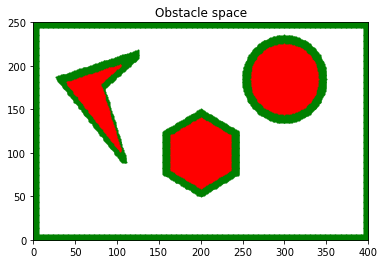

*******Starting A* Algorithm*******
True [54.0, 33.07179676972449, 300]
True [56.92820323027551, 36.0, 330]
True [58.0, 40.0, 0]
True [56.92820323027551, 44.0, 30]
True [54.0, 46.92820323027551, 60]
True [63.856406460551014, 40.0, 330]
True [64.9282032302755, 44.0, 0]
True [63.856406460551014, 48.0, 30]
True [60.92820323027551, 50.92820323027551, 60]
True [56.92820323027551, 52.0, 90]
True [70.78460969082653, 44.0, 330]
True [71.85640646055101, 48.0, 0]
True [70.78460969082653, 52.0, 30]
True [67.85640646055101, 54.92820323027551, 60]
True [63.856406460551014, 56.0, 90]
True [77.71281292110204, 48.0, 330]
True [78.78460969082653, 52.0, 0]
True [77.71281292110204, 56.0, 30]
True [74.78460969082653, 58.92820323027551, 60]
True [70.78460969082653, 60.0, 90]
True [84.64101615137756, 52.0, 330]
True [85.71281292110204, 56.0, 0]
True [84.64101615137756, 60.0, 30]
True [81.71281292110204, 62.92820323027551, 60]
True [77.71281292110204, 64.0, 90]
True [91.56921938165307, 56.0, 330]
True [92.64

True [255.20508075688764, 140.0, 270]
True [259.20508075688764, 141.0717967697245, 300]
True [262.13328398716317, 144.0, 330]
True [263.20508075688764, 148.0, 360]
True [262.13328398716317, 152.0, 30]
True [262.13328398716317, 144.0, 330]
True [263.20508075688764, 148.0, 0]
True [262.13328398716317, 152.0, 30]
True [259.20508075688764, 154.9282032302755, 60]
True [255.20508075688764, 156.0, 90]
True [261.34867429633664, 154.9282032302755, 0]
True [260.27687752661217, 158.9282032302755, 30]
True [257.34867429633664, 161.856406460551, 60]
True [253.34867429633664, 162.9282032302755, 90]
True [249.34867429633664, 161.856406460551, 120]
True [260.2768775266121, 145.0717967697245, 300]
True [263.20508075688764, 148.0, 330]
True [264.2768775266121, 152.0, 0]
True [263.20508075688764, 156.0, 30]
True [260.2768775266121, 158.9282032302755, 60]
True [257.34867429633664, 140.0, 270]
True [261.34867429633664, 141.0717967697245, 300]
True [264.27687752661217, 144.0, 330]
True [265.34867429633664, 

True [254.42047106606117, 137.0717967697245, 270]
True [258.42047106606117, 138.143593539449, 300]
True [242.42047106606117, 152.0, 120]
True [239.49226783578567, 149.0717967697245, 150]
True [238.42047106606117, 145.0717967697245, 180]
True [239.49226783578567, 141.0717967697245, 210]
True [242.42047106606117, 138.143593539449, 240]
True [242.42047106606114, 136.0, 210]
True [245.34867429633664, 133.0717967697245, 240]
True [249.34867429633664, 132.0, 270]
True [253.34867429633664, 133.0717967697245, 300]
True [256.27687752661217, 136.0, 330]
True [255.20508075688764, 164.0, 30]
True [252.27687752661214, 166.9282032302755, 60]
True [248.27687752661214, 168.0, 90]
True [244.27687752661214, 166.9282032302755, 120]
True [241.34867429633664, 164.0, 150]
True [255.20508075688764, 142.143593539449, 240]
True [259.20508075688764, 141.0717967697245, 270]
True [263.20508075688764, 142.143593539449, 300]
True [266.13328398716317, 145.0717967697245, 330]
True [267.20508075688764, 149.07179676972

True [246.42047106606114, 131.2153903091735, 240]
True [250.42047106606114, 130.143593539449, 270]
True [254.42047106606114, 131.2153903091735, 300]
True [257.34867429633664, 134.143593539449, 330]
True [258.42047106606117, 138.143593539449, 360]
True [241.34867429633664, 156.0, 90]
True [237.34867429633664, 154.9282032302755, 120]
True [234.42047106606114, 152.0, 150]
True [233.34867429633664, 148.0, 180]
True [234.42047106606114, 144.0, 210]
True [258.4204710660611, 165.856406460551, 60]
True [254.4204710660611, 166.9282032302755, 90]
True [250.4204710660611, 165.856406460551, 120]
True [247.4922678357856, 162.9282032302755, 150]
True [246.4204710660611, 158.9282032302755, 180]
True [242.42047106606117, 144.0, 150]
True [241.34867429633667, 140.0, 180]
True [242.42047106606117, 136.0, 210]
True [245.34867429633667, 133.0717967697245, 240]
True [249.34867429633667, 132.0, 270]
True [260.2768775266121, 164.7846096908265, 60]
True [256.2768775266121, 165.856406460551, 90]
True [252.2768

True [249.34867429633667, 156.0, 30]
True [246.42047106606117, 158.9282032302755, 60]
True [242.42047106606117, 160.0, 90]
True [238.42047106606117, 158.9282032302755, 120]
True [235.49226783578567, 156.0, 150]
True [267.2050807568877, 157.0717967697245, 30]
True [264.27687752661217, 160.0, 60]
True [260.27687752661217, 161.0717967697245, 90]
True [256.27687752661217, 160.0, 120]
True [253.34867429633667, 157.0717967697245, 150]
True [253.34867429633667, 165.0717967697245, 90]
True [249.34867429633667, 164.0, 120]
True [246.42047106606117, 161.0717967697245, 150]
True [245.34867429633667, 157.0717967697245, 180]
True [246.42047106606117, 153.0717967697245, 210]
True [239.49226783578567, 157.0717967697245, 150]
True [238.42047106606117, 153.0717967697245, 180]
True [239.49226783578567, 149.0717967697245, 210]
True [242.42047106606117, 146.143593539449, 240]
True [246.42047106606117, 145.0717967697245, 270]
True [239.49226783578567, 141.0717967697245, 210]
True [242.42047106606117, 138.1

True [238.42047106606114, 158.9282032302755, 120]
True [235.49226783578564, 156.0, 150]
True [234.42047106606114, 152.0, 180]
True [235.49226783578564, 148.0, 210]
True [238.42047106606114, 145.0717967697245, 240]
True [264.27687752661217, 138.143593539449, 330]
True [265.34867429633664, 142.143593539449, 0]
True [264.27687752661217, 146.143593539449, 30]
True [261.34867429633664, 149.0717967697245, 60]
True [257.34867429633664, 150.143593539449, 90]
True [264.27687752661217, 154.143593539449, 30]
True [261.34867429633664, 157.0717967697245, 60]
True [257.34867429633664, 158.143593539449, 90]
True [253.34867429633664, 157.0717967697245, 120]
True [250.42047106606114, 154.143593539449, 150]
True [250.42047106606114, 162.143593539449, 90]
True [246.42047106606114, 161.0717967697245, 120]
True [243.49226783578564, 158.143593539449, 150]
True [242.42047106606114, 154.143593539449, 180]
True [243.49226783578564, 150.143593539449, 210]
True [236.56406460551014, 154.143593539449, 150]
True [2

True [239.4922678357856, 141.0717967697245, 210]
True [253.3486742963366, 157.0717967697245, 30]
True [250.4204710660611, 160.0, 60]
True [246.4204710660611, 161.0717967697245, 90]
True [242.4204710660611, 160.0, 120]
True [239.4922678357856, 157.0717967697245, 150]
True [239.49226783578564, 133.0717967697245, 210]
True [242.42047106606114, 130.143593539449, 240]
True [246.42047106606114, 129.0717967697245, 270]
True [250.42047106606114, 130.143593539449, 300]
True [253.34867429633664, 133.0717967697245, 330]
True [250.42047106606114, 136.0, 210]
True [253.34867429633664, 133.0717967697245, 240]
True [257.34867429633664, 132.0, 270]
True [261.34867429633664, 133.0717967697245, 300]
True [264.27687752661217, 136.0, 330]
True [252.27687752661214, 161.0717967697245, 30]
True [249.34867429633664, 164.0, 60]
True [245.34867429633664, 165.0717967697245, 90]
True [241.34867429633664, 164.0, 120]
True [238.42047106606114, 161.0717967697245, 150]
True [234.4204710660611, 157.856406460551, 150]


True [265.0614872174387, 154.9282032302755, 30]
True [262.13328398716317, 157.856406460551, 60]
True [258.13328398716317, 158.9282032302755, 90]
True [254.13328398716317, 157.856406460551, 120]
True [252.27687752661214, 158.9282032302755, 0]
True [251.20508075688764, 162.9282032302755, 30]
True [248.27687752661214, 165.856406460551, 60]
True [244.27687752661214, 166.9282032302755, 90]
True [240.27687752661214, 165.856406460551, 120]
True [256.27687752661217, 152.0, 300]
True [259.20508075688764, 154.9282032302755, 330]
True [260.2768775266121, 158.9282032302755, 0]
True [259.20508075688764, 162.9282032302755, 30]
True [256.27687752661217, 165.856406460551, 60]
True [259.20508075688764, 162.9282032302755, 30]
True [256.27687752661217, 165.856406460551, 60]
True [252.27687752661214, 166.9282032302755, 90]
True [248.27687752661214, 165.856406460551, 120]
True [245.34867429633664, 162.9282032302755, 150]
True [240.27687752661214, 136.0, 210]
True [243.20508075688764, 133.0717967697245, 240

True [249.3486742963366, 164.0, 90]
True [245.3486742963366, 162.9282032302755, 120]
True [242.4204710660611, 160.0, 150]
True [241.3486742963366, 156.0, 180]
True [242.4204710660611, 152.0, 210]
True [245.3486742963366, 162.9282032302755, 90]
True [241.3486742963366, 161.856406460551, 120]
True [238.4204710660611, 158.9282032302755, 150]
True [237.3486742963366, 154.9282032302755, 180]
True [238.4204710660611, 150.9282032302755, 210]
True [251.20508075688764, 168.7846096908265, 60]
True [247.20508075688764, 169.856406460551, 90]
True [243.20508075688764, 168.7846096908265, 120]
True [240.27687752661214, 165.856406460551, 150]
True [239.20508075688764, 161.856406460551, 180]
True [258.13328398716317, 137.0717967697245, 300]
True [261.0614872174387, 140.0, 330]
True [262.13328398716317, 144.0, 360]
True [261.0614872174387, 148.0, 30]
True [258.13328398716317, 150.9282032302755, 60]
True [266.13328398716317, 145.0717967697245, 300]
True [269.0614872174387, 148.0, 330]
True [270.133283987

True [243.20508075688764, 149.0717967697245, 240]
True [235.20508075688764, 149.0717967697245, 180]
True [236.27687752661214, 145.0717967697245, 210]
True [239.20508075688764, 142.143593539449, 240]
True [243.20508075688764, 141.0717967697245, 270]
True [247.20508075688764, 142.143593539449, 300]
True [260.2768775266121, 153.0717967697245, 330]
True [261.34867429633664, 157.0717967697245, 0]
True [260.2768775266121, 161.0717967697245, 30]
True [257.34867429633664, 164.0, 60]
True [253.3486742963366, 165.0717967697245, 90]
True [263.20508075688764, 134.143593539449, 300]
True [266.13328398716317, 137.0717967697245, 330]
True [267.20508075688764, 141.0717967697245, 360]
True [266.13328398716317, 145.0717967697245, 30]
True [263.20508075688764, 148.0, 60]
True [263.20508075688764, 134.143593539449, 300]
True [266.13328398716317, 137.0717967697245, 330]
True [267.20508075688764, 141.0717967697245, 0]
True [266.13328398716317, 145.0717967697245, 30]
True [263.20508075688764, 148.0, 60]
True

True [247.20508075688764, 148.0, 210]
True [250.13328398716314, 145.0717967697245, 240]
True [254.13328398716314, 144.0, 270]
True [258.13328398716317, 145.0717967697245, 300]
True [261.06148721743864, 148.0, 330]
True [240.27687752661214, 152.0, 150]
True [239.20508075688764, 148.0, 180]
True [240.27687752661214, 144.0, 210]
True [243.20508075688764, 141.0717967697245, 240]
True [247.20508075688764, 140.0, 270]
True [242.13328398716314, 145.0717967697245, 180]
True [243.20508075688764, 141.0717967697245, 210]
True [246.13328398716314, 138.143593539449, 240]
True [250.13328398716314, 137.0717967697245, 270]
True [254.13328398716314, 138.143593539449, 300]
True [254.13328398716317, 146.143593539449, 240]
True [258.13328398716317, 145.0717967697245, 270]
True [262.13328398716317, 146.143593539449, 300]
True [265.0614872174387, 149.0717967697245, 330]
True [266.13328398716317, 153.0717967697245, 360]
True [246.13328398716317, 146.143593539449, 180]
True [247.20508075688767, 142.1435935394

True [232.2768775266121, 146.143593539449, 180]
True [233.3486742963366, 142.143593539449, 210]
True [236.2768775266121, 139.2153903091735, 240]
True [260.27687752661217, 134.9282032302755, 270]
True [264.27687752661217, 136.0, 300]
True [267.2050807568877, 138.9282032302755, 330]
True [268.27687752661217, 142.9282032302755, 360]
True [267.2050807568877, 146.9282032302755, 30]
True [253.34867429633667, 138.9282032302755, 210]
True [256.27687752661217, 136.0, 240]
True [260.27687752661217, 134.9282032302755, 270]
True [264.27687752661217, 136.0, 300]
True [267.2050807568877, 138.9282032302755, 330]
True [245.34867429633664, 160.7846096908265, 60]
True [241.34867429633664, 161.856406460551, 90]
True [237.34867429633664, 160.7846096908265, 120]
True [234.42047106606114, 157.856406460551, 150]
True [233.34867429633664, 153.856406460551, 180]
True [244.56406460551017, 157.856406460551, 60]
True [240.56406460551017, 158.9282032302755, 90]
True [236.56406460551017, 157.856406460551, 120]
True

True [257.34867429633664, 156.0, 90]
True [240.56406460551017, 153.0717967697245, 90]
True [236.56406460551017, 152.0, 120]
True [233.63586137523467, 149.0717967697245, 150]
True [232.56406460551017, 145.0717967697245, 180]
True [233.63586137523467, 141.0717967697245, 210]
True [247.49226783578564, 133.0717967697245, 210]
True [250.42047106606114, 130.143593539449, 240]
True [254.42047106606114, 129.0717967697245, 270]
True [258.42047106606117, 130.143593539449, 300]
True [261.34867429633664, 133.0717967697245, 330]
True [235.4922678357856, 140.0, 210]
True [238.4204710660611, 137.0717967697245, 240]
True [242.4204710660611, 136.0, 270]
True [246.4204710660611, 137.0717967697245, 300]
True [249.3486742963366, 140.0, 330]
True [240.27687752661214, 152.0, 330]
True [241.34867429633664, 156.0, 0]
True [240.27687752661214, 160.0, 30]
True [237.34867429633664, 162.9282032302755, 60]
True [233.34867429633664, 164.0, 90]
True [240.27687752661214, 144.0, 270]
True [244.27687752661214, 145.0717

True [258.13328398716317, 139.2153903091735, 300]
True [261.0614872174387, 142.143593539449, 330]
True [262.13328398716317, 146.143593539449, 360]
True [261.0614872174387, 150.143593539449, 30]
True [258.13328398716317, 153.0717967697245, 60]
True [242.13328398716317, 139.2153903091735, 180]
True [243.20508075688767, 135.2153903091735, 210]
True [246.13328398716317, 132.287187078898, 240]
True [250.13328398716317, 131.2153903091735, 270]
True [254.13328398716317, 132.287187078898, 300]
True [250.13328398716314, 161.0717967697245, 30]
True [247.20508075688764, 164.0, 60]
True [243.20508075688764, 165.0717967697245, 90]
True [239.20508075688764, 164.0, 120]
True [236.27687752661214, 161.0717967697245, 150]
True [260.27687752661217, 166.9282032302755, 60]
True [256.27687752661217, 168.0, 90]
True [252.27687752661217, 166.9282032302755, 120]
True [249.34867429633667, 164.0, 150]
True [248.27687752661217, 160.0, 180]
True [244.27687752661217, 166.9282032302755, 120]
True [241.34867429633667

True [239.20508075688764, 140.0, 270]
True [243.20508075688764, 141.0717967697245, 300]
True [243.20508075688764, 154.9282032302755, 60]
True [239.20508075688764, 156.0, 90]
True [235.20508075688764, 154.9282032302755, 120]
True [232.27687752661214, 152.0, 150]
True [231.20508075688764, 148.0, 180]
True [251.20508075688764, 154.9282032302755, 0]
True [250.13328398716314, 158.9282032302755, 30]
True [247.20508075688764, 161.856406460551, 60]
True [243.20508075688764, 162.9282032302755, 90]
True [239.20508075688764, 161.856406460551, 120]
True [255.20508075688764, 148.0, 300]
True [258.13328398716317, 150.9282032302755, 330]
True [259.20508075688764, 154.9282032302755, 0]
True [258.13328398716317, 158.9282032302755, 30]
True [255.20508075688764, 161.856406460551, 60]
True [251.20508075688764, 141.0717967697245, 240]
True [255.20508075688764, 140.0, 270]
True [259.20508075688764, 141.0717967697245, 300]
True [262.13328398716317, 144.0, 330]
True [263.20508075688764, 148.0, 360]
True [257.

True [249.3486742963366, 142.143593539449, 210]
True [252.2768775266121, 139.2153903091735, 240]
True [256.2768775266121, 138.143593539449, 270]
True [260.2768775266121, 139.2153903091735, 300]
True [263.20508075688764, 142.143593539449, 330]
True [243.20508075688764, 133.0717967697245, 240]
True [247.20508075688764, 132.0, 270]
True [251.20508075688764, 133.0717967697245, 300]
True [254.13328398716314, 136.0, 330]
True [255.20508075688764, 140.0, 360]
True [239.49226783578564, 141.0717967697245, 150]
True [238.42047106606114, 137.0717967697245, 180]
True [239.49226783578564, 133.0717967697245, 210]
True [242.42047106606114, 130.143593539449, 240]
True [246.42047106606114, 129.0717967697245, 270]
True [238.42047106606114, 137.0717967697245, 180]
True [239.49226783578564, 133.0717967697245, 210]
True [242.42047106606114, 130.143593539449, 240]
True [246.42047106606114, 129.0717967697245, 270]
True [250.42047106606114, 130.143593539449, 300]
True [248.27687752661217, 138.143593539449, 18

True [251.49226783578567, 164.0, 90]
True [247.49226783578567, 162.9282032302755, 120]
True [244.56406460551017, 160.0, 150]
True [243.49226783578567, 156.0, 180]
True [244.56406460551017, 152.0, 210]
True [237.63586137523467, 156.0, 150]
True [236.56406460551017, 152.0, 180]
True [237.63586137523467, 148.0, 210]
True [240.56406460551017, 145.0717967697245, 240]
True [244.56406460551017, 144.0, 270]
True [236.56406460551017, 152.0, 150]
True [235.49226783578567, 148.0, 180]
True [236.56406460551017, 144.0, 210]
True [239.49226783578567, 141.0717967697245, 240]
True [243.49226783578567, 140.0, 270]
True [239.49226783578567, 162.9282032302755, 120]
True [236.56406460551017, 160.0, 150]
True [235.49226783578567, 156.0, 180]
True [236.56406460551017, 152.0, 210]
True [239.49226783578567, 149.0717967697245, 240]
True [237.63586137523467, 140.0, 210]
True [240.56406460551017, 137.0717967697245, 240]
True [244.56406460551017, 136.0, 270]
True [248.56406460551017, 137.0717967697245, 300]
True 

True [258.42047106606117, 144.0, 270]
True [262.42047106606117, 145.0717967697245, 300]
True [265.3486742963367, 148.0, 330]
True [266.42047106606117, 152.0, 360]
True [265.3486742963367, 156.0, 30]
True [233.63586137523464, 141.0717967697245, 210]
True [236.56406460551014, 138.143593539449, 240]
True [240.56406460551014, 137.0717967697245, 270]
True [244.56406460551014, 138.143593539449, 300]
True [247.49226783578564, 141.0717967697245, 330]
True [247.49226783578564, 133.0717967697245, 270]
True [251.49226783578564, 134.143593539449, 300]
True [254.42047106606114, 137.0717967697245, 330]
True [255.49226783578564, 141.0717967697245, 360]
True [254.42047106606114, 145.0717967697245, 30]
True [261.34867429633664, 141.0717967697245, 330]
True [262.42047106606117, 145.0717967697245, 0]
True [261.34867429633664, 149.0717967697245, 30]
True [258.42047106606117, 152.0, 60]
True [254.42047106606114, 153.0717967697245, 90]
True [250.42047106606114, 130.143593539449, 240]
True [254.4204710660611

True [239.20508075688767, 158.143593539449, 90]
True [235.20508075688767, 157.0717967697245, 120]
True [232.27687752661217, 154.143593539449, 150]
True [231.20508075688767, 150.143593539449, 180]
True [232.27687752661217, 146.143593539449, 210]
True [251.20508075688764, 141.0717967697245, 180]
True [252.27687752661214, 137.0717967697245, 210]
True [255.20508075688764, 134.143593539449, 240]
True [259.20508075688764, 133.0717967697245, 270]
True [263.20508075688764, 134.143593539449, 300]
True [247.20508075688764, 148.0, 120]
True [244.27687752661214, 145.0717967697245, 150]
True [243.20508075688764, 141.0717967697245, 180]
True [244.27687752661214, 137.0717967697245, 210]
True [247.20508075688764, 134.143593539449, 240]
True [251.20508075688764, 154.9282032302755, 60]
True [247.20508075688764, 156.0, 90]
True [243.20508075688764, 154.9282032302755, 120]
True [240.27687752661214, 152.0, 150]
True [239.20508075688764, 148.0, 180]
True [247.20508075688764, 161.856406460551, 60]
True [243.

True [250.13328398716314, 166.9282032302755, 90]
True [246.13328398716314, 165.856406460551, 120]
True [243.20508075688764, 162.9282032302755, 150]
True [242.13328398716314, 158.9282032302755, 180]
True [243.20508075688764, 154.9282032302755, 210]
True [236.27687752661214, 158.9282032302755, 150]
True [235.20508075688764, 154.9282032302755, 180]
True [236.27687752661214, 150.9282032302755, 210]
True [239.20508075688764, 148.0, 240]
True [243.20508075688764, 146.9282032302755, 270]
True [234.13328398716314, 145.0717967697245, 180]
True [235.20508075688764, 141.0717967697245, 210]
True [238.13328398716314, 138.143593539449, 240]
True [242.13328398716314, 137.0717967697245, 270]
True [246.13328398716314, 138.143593539449, 300]
True [245.06148721743864, 134.143593539449, 240]
True [249.06148721743864, 133.0717967697245, 270]
True [253.06148721743864, 134.143593539449, 300]
True [255.98969044771414, 137.0717967697245, 330]
True [257.06148721743864, 141.0717967697245, 360]
True [237.06148721

True [262.42047106606117, 158.9282032302755, 30]
True [259.49226783578564, 161.856406460551, 60]
True [261.34867429633664, 154.9282032302755, 330]
True [262.42047106606117, 158.9282032302755, 0]
True [261.34867429633664, 162.9282032302755, 30]
True [258.42047106606117, 165.856406460551, 60]
True [254.42047106606114, 166.9282032302755, 90]
True [257.34867429633664, 156.0, 330]
True [258.42047106606117, 160.0, 0]
True [257.34867429633664, 164.0, 30]
True [254.42047106606114, 166.9282032302755, 60]
True [250.42047106606114, 168.0, 90]
True [241.34867429633667, 145.856406460551, 120]
True [238.42047106606117, 142.9282032302755, 150]
True [237.34867429633667, 138.9282032302755, 180]
True [238.42047106606117, 134.9282032302755, 210]
True [241.34867429633667, 132.0, 240]
True [245.34867429633667, 152.7846096908265, 60]
True [241.34867429633667, 153.856406460551, 90]
True [237.34867429633667, 152.7846096908265, 120]
True [234.42047106606117, 149.856406460551, 150]
True [233.34867429633667, 145

True [243.20508075688764, 146.9282032302755, 150]
True [242.13328398716314, 142.9282032302755, 180]
True [243.20508075688764, 138.9282032302755, 210]
True [246.13328398716314, 136.0, 240]
True [250.13328398716314, 134.9282032302755, 270]
True [245.34867429633664, 162.9282032302755, 0]
True [244.27687752661214, 166.9282032302755, 30]
True [241.34867429633664, 169.856406460551, 60]
True [237.34867429633664, 170.9282032302755, 90]
True [233.34867429633664, 169.856406460551, 120]
True [249.34867429633664, 156.0, 300]
True [252.27687752661214, 158.9282032302755, 330]
True [253.34867429633664, 162.9282032302755, 0]
True [252.27687752661214, 166.9282032302755, 30]
True [249.34867429633664, 169.856406460551, 60]
True [245.34867429633664, 149.0717967697245, 240]
True [249.34867429633664, 148.0, 270]
True [253.34867429633664, 149.0717967697245, 300]
True [256.27687752661217, 152.0, 330]
True [257.34867429633664, 156.0, 360]
True [242.42047106606114, 144.0, 210]
True [245.34867429633664, 141.0717

True [265.3486742963367, 150.143593539449, 30]
True [262.42047106606117, 153.0717967697245, 60]
True [254.13328398716317, 130.143593539449, 240]
True [258.13328398716317, 129.0717967697245, 270]
True [262.13328398716317, 130.143593539449, 300]
True [265.0614872174387, 133.0717967697245, 330]
True [266.13328398716317, 137.0717967697245, 360]
True [258.13328398716317, 129.0717967697245, 270]
True [262.13328398716317, 130.143593539449, 300]
True [265.0614872174387, 133.0717967697245, 330]
True [266.13328398716317, 137.0717967697245, 360]
True [265.0614872174387, 141.0717967697245, 30]
True [247.20508075688764, 172.0, 90]
True [243.20508075688764, 170.9282032302755, 120]
True [240.27687752661214, 168.0, 150]
True [239.20508075688764, 164.0, 180]
True [240.27687752661214, 160.0, 210]
True [265.34867429633664, 153.856406460551, 0]
True [264.27687752661217, 157.856406460551, 30]
True [261.34867429633664, 160.7846096908265, 60]
True [257.34867429633664, 161.856406460551, 90]
True [253.34867429

True [256.2768775266121, 130.143593539449, 270]
True [260.2768775266121, 131.2153903091735, 300]
True [263.20508075688764, 134.143593539449, 330]
True [259.20508075688764, 135.2153903091735, 300]
True [262.13328398716317, 138.143593539449, 330]
True [263.20508075688764, 142.143593539449, 360]
True [262.13328398716317, 146.143593539449, 30]
True [259.20508075688764, 149.0717967697245, 60]
True [255.20508075688767, 134.143593539449, 270]
True [259.2050807568877, 135.2153903091735, 300]
True [262.13328398716317, 138.143593539449, 330]
True [263.2050807568877, 142.143593539449, 360]
True [262.13328398716317, 146.143593539449, 30]
True [250.42047106606114, 162.143593539449, 30]
True [247.49226783578564, 165.0717967697245, 60]
True [243.49226783578564, 166.143593539449, 90]
True [239.49226783578564, 165.0717967697245, 120]
True [236.56406460551014, 162.143593539449, 150]
True [254.42047106606117, 142.9282032302755, 240]
True [258.42047106606117, 141.856406460551, 270]
True [262.4204710660611

True [242.4204710660611, 168.0, 90]
True [238.4204710660611, 166.9282032302755, 120]
True [235.4922678357856, 164.0, 150]
True [234.4204710660611, 160.0, 180]
True [235.4922678357856, 156.0, 210]
True [231.49226783578567, 149.0717967697245, 180]
True [232.56406460551017, 145.0717967697245, 210]
True [235.49226783578567, 142.143593539449, 240]
True [239.49226783578567, 141.0717967697245, 270]
True [243.49226783578567, 142.143593539449, 300]
True [250.13328398716314, 131.2153903091735, 240]
True [254.13328398716314, 130.143593539449, 270]
True [258.13328398716317, 131.2153903091735, 300]
True [261.06148721743864, 134.143593539449, 330]
True [262.13328398716317, 138.143593539449, 360]
True [247.20508075688767, 134.143593539449, 210]
True [250.13328398716317, 131.2153903091735, 240]
True [254.13328398716317, 130.143593539449, 270]
True [258.13328398716317, 131.2153903091735, 300]
True [261.0614872174387, 134.143593539449, 330]
True [232.27687752661217, 141.856406460551, 210]
True [235.2050

True [255.49226783578564, 151.2153903091735, 60]
True [263.49226783578564, 151.2153903091735, 0]
True [262.42047106606117, 155.2153903091735, 30]
True [259.49226783578564, 158.143593539449, 60]
True [255.49226783578564, 159.2153903091735, 90]
True [251.49226783578564, 158.143593539449, 120]
True [254.13328398716317, 140.287187078898, 240]
True [258.13328398716317, 139.2153903091735, 270]
True [262.13328398716317, 140.287187078898, 300]
True [265.0614872174387, 143.2153903091735, 330]
True [266.13328398716317, 147.2153903091735, 360]
True [265.0614872174387, 143.2153903091735, 330]
True [266.13328398716317, 147.2153903091735, 0]
True [265.0614872174387, 151.2153903091735, 30]
True [262.13328398716317, 154.143593539449, 60]
True [258.13328398716317, 155.2153903091735, 90]
True [243.49226783578564, 161.856406460551, 60]
True [239.49226783578564, 162.9282032302755, 90]
True [235.49226783578564, 161.856406460551, 120]
True [232.56406460551014, 158.9282032302755, 150]
True [231.4922678357856

True [254.13328398716317, 160.0, 120]
True [237.34867429633664, 135.2153903091735, 240]
True [241.34867429633664, 134.143593539449, 270]
True [245.34867429633664, 135.2153903091735, 300]
True [248.27687752661214, 138.143593539449, 330]
True [249.34867429633664, 142.143593539449, 360]
True [253.34867429633664, 135.2153903091735, 300]
True [256.27687752661217, 138.143593539449, 330]
True [257.34867429633664, 142.143593539449, 360]
True [256.27687752661217, 146.143593539449, 30]
True [253.34867429633664, 149.0717967697245, 60]
True [261.34867429633664, 149.0717967697245, 0]
True [260.27687752661217, 153.0717967697245, 30]
True [257.34867429633664, 156.0, 60]
True [253.34867429633664, 157.0717967697245, 90]
True [249.34867429633664, 156.0, 120]
True [253.34867429633664, 162.9282032302755, 60]
True [249.34867429633664, 164.0, 90]
True [245.34867429633664, 162.9282032302755, 120]
True [242.42047106606114, 160.0, 150]
True [241.34867429633664, 156.0, 180]
True [266.13328398716317, 142.9282032

True [252.27687752661214, 166.9282032302755, 0]
True [251.20508075688764, 170.9282032302755, 30]
True [248.27687752661214, 173.856406460551, 60]
True [244.27687752661214, 174.9282032302755, 90]
True [240.27687752661214, 173.856406460551, 120]
True [251.20508075688764, 162.9282032302755, 330]
True [252.27687752661214, 166.9282032302755, 0]
True [251.20508075688764, 170.9282032302755, 30]
True [248.27687752661214, 173.856406460551, 60]
True [244.27687752661214, 174.9282032302755, 90]
True [251.20508075688764, 154.9282032302755, 270]
True [255.20508075688764, 156.0, 300]
True [258.13328398716317, 158.9282032302755, 330]
True [259.20508075688764, 162.9282032302755, 360]
True [258.13328398716317, 166.9282032302755, 30]
True [244.27687752661214, 150.9282032302755, 210]
True [247.20508075688764, 148.0, 240]
True [251.20508075688764, 146.9282032302755, 270]
True [255.20508075688764, 148.0, 300]
True [258.13328398716317, 150.9282032302755, 330]
True [244.27687752661214, 142.9282032302755, 210]


True [256.27687752661217, 171.712812921102, 60]
True [252.27687752661217, 172.7846096908265, 90]
True [248.27687752661217, 171.712812921102, 120]
True [245.34867429633667, 168.7846096908265, 150]
True [244.27687752661217, 164.7846096908265, 180]
True [247.20508075688764, 126.143593539449, 240]
True [251.20508075688764, 125.0717967697245, 270]
True [255.20508075688764, 126.14359353944899, 300]
True [258.13328398716317, 129.0717967697245, 330]
True [259.20508075688764, 133.0717967697245, 360]
True [251.20508075688764, 125.0717967697245, 270]
True [255.20508075688764, 126.14359353944899, 300]
True [258.13328398716317, 129.0717967697245, 330]
True [259.20508075688764, 133.0717967697245, 360]
True [258.13328398716317, 137.0717967697245, 30]
True [265.0614872174387, 133.0717967697245, 330]
True [266.13328398716317, 137.0717967697245, 0]
True [265.0614872174387, 141.0717967697245, 30]
True [262.13328398716317, 144.0, 60]
True [258.13328398716317, 145.0717967697245, 90]
True [265.0614872174387

True [253.34867429633667, 146.9282032302755, 300]
True [256.27687752661217, 149.856406460551, 330]
True [257.34867429633664, 153.856406460551, 0]
True [256.27687752661217, 157.856406460551, 30]
True [253.34867429633667, 160.7846096908265, 60]
True [249.34867429633667, 140.0, 240]
True [253.34867429633667, 138.9282032302755, 270]
True [257.3486742963367, 140.0, 300]
True [260.27687752661217, 142.9282032302755, 330]
True [261.34867429633664, 146.9282032302755, 360]
True [256.27687752661217, 141.856406460551, 270]
True [260.27687752661217, 142.9282032302755, 300]
True [263.2050807568877, 145.856406460551, 330]
True [264.27687752661217, 149.856406460551, 360]
True [263.2050807568877, 153.856406460551, 30]
True [261.34867429633664, 146.9282032302755, 300]
True [264.27687752661217, 149.856406460551, 330]
True [265.34867429633664, 153.856406460551, 0]
True [264.27687752661217, 157.856406460551, 30]
True [261.34867429633664, 160.7846096908265, 60]
True [241.34867429633664, 153.856406460551, 60

True [252.27687752661217, 145.0717967697245, 270]
True [256.27687752661217, 146.143593539449, 300]
True [249.34867429633667, 148.0, 210]
True [252.27687752661217, 145.0717967697245, 240]
True [256.27687752661217, 144.0, 270]
True [260.27687752661217, 145.0717967697245, 300]
True [263.2050807568877, 148.0, 330]
True [242.42047106606117, 152.0, 150]
True [241.34867429633667, 148.0, 180]
True [242.42047106606117, 144.0, 210]
True [245.34867429633667, 141.0717967697245, 240]
True [249.34867429633667, 140.0, 270]
True [271.9896904477142, 145.0717967697245, 330]
True [273.0614872174387, 149.0717967697245, 0]
True [271.9896904477142, 153.0717967697245, 30]
True [269.0614872174387, 156.0, 60]
True [265.0614872174387, 157.0717967697245, 90]
True [239.20508075688764, 134.143593539449, 180]
True [240.27687752661214, 130.143593539449, 210]
True [243.20508075688764, 127.2153903091735, 240]
True [247.20508075688764, 126.143593539449, 270]
True [251.20508075688764, 127.21539030917349, 300]
True [258.

True [259.98969044771417, 144.0, 270]
True [263.98969044771417, 145.0717967697245, 300]
True [266.9178936779897, 148.0, 330]
True [267.98969044771417, 152.0, 360]
True [266.9178936779897, 156.0, 30]
True [236.27687752661214, 137.0717967697245, 210]
True [239.20508075688764, 134.143593539449, 240]
True [243.20508075688764, 133.0717967697245, 270]
True [247.20508075688764, 134.143593539449, 300]
True [250.13328398716314, 137.0717967697245, 330]
True [267.20508075688764, 149.0717967697245, 0]
True [266.13328398716317, 153.0717967697245, 30]
True [263.20508075688764, 156.0, 60]
True [259.20508075688764, 157.0717967697245, 90]
True [255.20508075688764, 156.0, 120]
True [256.5640646055101, 164.7846096908265, 60]
True [252.5640646055101, 165.856406460551, 90]
True [248.5640646055101, 164.7846096908265, 120]
True [245.6358613752346, 161.856406460551, 150]
True [244.5640646055101, 157.856406460551, 180]
True [251.20508075688767, 133.0717967697245, 210]
True [254.13328398716317, 130.143593539449

True [251.20508075688767, 157.0717967697245, 0]
True [250.13328398716317, 161.0717967697245, 30]
True [247.20508075688767, 164.0, 60]
True [243.20508075688767, 165.0717967697245, 90]
True [239.20508075688767, 164.0, 120]
True [255.20508075688767, 150.143593539449, 300]
True [258.13328398716317, 153.0717967697245, 330]
True [259.2050807568877, 157.0717967697245, 0]
True [258.13328398716317, 161.0717967697245, 30]
True [255.20508075688767, 164.0, 60]
True [251.20508075688767, 143.2153903091735, 240]
True [255.20508075688767, 142.143593539449, 270]
True [259.2050807568877, 143.2153903091735, 300]
True [262.13328398716317, 146.143593539449, 330]
True [263.2050807568877, 150.143593539449, 360]
True [243.20508075688767, 143.2153903091735, 180]
True [244.27687752661217, 139.2153903091735, 210]
True [247.20508075688767, 136.287187078898, 240]
True [251.20508075688767, 135.2153903091735, 270]
True [255.20508075688767, 136.287187078898, 300]
True [246.13328398716317, 138.143593539449, 210]
True 

True [242.42047106606117, 152.0, 90]
True [238.42047106606117, 150.9282032302755, 120]
True [235.49226783578567, 148.0, 150]
True [234.42047106606117, 144.0, 180]
True [254.42047106606117, 150.9282032302755, 0]
True [253.34867429633667, 154.9282032302755, 30]
True [250.42047106606117, 157.856406460551, 60]
True [246.42047106606117, 158.9282032302755, 90]
True [242.42047106606117, 157.856406460551, 120]
True [258.42047106606117, 144.0, 300]
True [261.3486742963367, 146.9282032302755, 330]
True [262.42047106606117, 150.9282032302755, 0]
True [261.3486742963367, 154.9282032302755, 30]
True [258.42047106606117, 157.856406460551, 60]
True [242.42047106606114, 144.0, 120]
True [239.49226783578564, 141.0717967697245, 150]
True [238.42047106606114, 137.0717967697245, 180]
True [239.49226783578564, 133.0717967697245, 210]
True [242.42047106606114, 130.143593539449, 240]
True [226.42047106606114, 136.0, 210]
True [229.34867429633664, 133.0717967697245, 240]
True [233.34867429633664, 132.0, 270]


True [244.27687752661217, 139.2153903091735, 300]
True [247.20508075688767, 142.143593539449, 330]
True [247.20508075688767, 134.143593539449, 270]
True [251.20508075688767, 135.2153903091735, 300]
True [254.13328398716317, 138.143593539449, 330]
True [255.20508075688767, 142.143593539449, 360]
True [254.13328398716317, 146.143593539449, 30]
True [261.0614872174387, 142.143593539449, 330]
True [262.13328398716317, 146.143593539449, 0]
True [261.0614872174387, 150.143593539449, 30]
True [258.13328398716317, 153.0717967697245, 60]
True [254.13328398716317, 154.143593539449, 90]
True [261.0614872174387, 158.143593539449, 30]
True [258.13328398716317, 161.0717967697245, 60]
True [254.13328398716317, 162.143593539449, 90]
True [250.13328398716317, 161.0717967697245, 120]
True [247.20508075688767, 158.143593539449, 150]
True [269.34867429633664, 141.0717967697245, 300]
True [272.27687752661217, 144.0, 330]
True [273.34867429633664, 148.0, 0]
True [272.27687752661217, 152.0, 30]
True [269.348

True [248.2768775266121, 157.856406460551, 120]
True [245.3486742963366, 154.9282032302755, 150]
True [244.2768775266121, 150.9282032302755, 180]
True [245.3486742963366, 146.9282032302755, 210]
True [248.2768775266121, 144.0, 240]
True [249.34867429633667, 164.0, 30]
True [246.42047106606117, 166.9282032302755, 60]
True [242.42047106606117, 168.0, 90]
True [238.42047106606117, 166.9282032302755, 120]
True [235.49226783578567, 164.0, 150]
True [250.42047106606114, 160.0, 0]
True [249.34867429633664, 164.0, 30]
True [246.42047106606114, 166.9282032302755, 60]
True [242.42047106606114, 168.0, 90]
True [238.42047106606114, 166.9282032302755, 120]
True [254.42047106606114, 153.0717967697245, 300]
True [257.34867429633664, 156.0, 330]
True [258.42047106606117, 160.0, 0]
True [257.34867429633664, 164.0, 30]
True [254.42047106606114, 166.9282032302755, 60]
True [250.42047106606114, 146.143593539449, 240]
True [254.42047106606114, 145.0717967697245, 270]
True [258.42047106606117, 146.143593539

True [263.2050807568877, 142.143593539449, 270]
True [267.2050807568877, 143.2153903091735, 300]
True [270.1332839871632, 146.143593539449, 330]
True [271.2050807568877, 150.143593539449, 360]
True [270.1332839871632, 154.143593539449, 30]
True [241.34867429633664, 126.143593539449, 270]
True [245.34867429633664, 127.21539030917349, 300]
True [248.27687752661214, 130.143593539449, 330]
True [249.34867429633664, 134.143593539449, 360]
True [248.27687752661214, 138.143593539449, 30]
True [255.20508075688764, 134.143593539449, 330]
True [256.2768775266121, 138.143593539449, 0]
True [255.20508075688764, 142.143593539449, 30]
True [252.27687752661214, 145.0717967697245, 60]
True [248.27687752661214, 146.143593539449, 90]
True [255.20508075688764, 150.143593539449, 30]
True [252.27687752661214, 153.0717967697245, 60]
True [248.27687752661214, 154.143593539449, 90]
True [244.27687752661214, 153.0717967697245, 120]
True [241.34867429633664, 150.143593539449, 150]
True [260.2768775266121, 153.0

True [239.4922678357856, 162.9282032302755, 90]
True [235.4922678357856, 161.856406460551, 120]
True [232.5640646055101, 158.9282032302755, 150]
True [231.4922678357856, 154.9282032302755, 180]
True [232.5640646055101, 150.9282032302755, 210]
True [265.0614872174387, 154.9282032302755, 0]
True [263.9896904477142, 158.9282032302755, 30]
True [261.0614872174387, 161.856406460551, 60]
True [257.0614872174387, 162.9282032302755, 90]
True [253.0614872174387, 161.856406460551, 120]
True [267.20508075688764, 152.7846096908265, 0]
True [266.13328398716317, 156.7846096908265, 30]
True [263.20508075688764, 159.712812921102, 60]
True [259.20508075688764, 160.7846096908265, 90]
True [255.20508075688764, 159.712812921102, 120]
True [259.20508075688764, 144.7846096908265, 270]
True [263.20508075688764, 145.856406460551, 300]
True [266.13328398716317, 148.7846096908265, 330]
True [267.20508075688764, 152.7846096908265, 360]
True [266.13328398716317, 156.7846096908265, 30]
True [231.49226783578564, 16

True [243.49226783578564, 161.856406460551, 120]
True [240.56406460551014, 158.9282032302755, 150]
True [239.49226783578564, 154.9282032302755, 180]
True [240.56406460551014, 150.9282032302755, 210]
True [243.49226783578564, 148.0, 240]
True [235.20508075688764, 146.9282032302755, 120]
True [232.27687752661214, 144.0, 150]
True [231.20508075688764, 140.0, 180]
True [232.27687752661214, 136.0, 210]
True [235.20508075688764, 133.0717967697245, 240]
True [236.56406460551014, 152.0, 90]
True [232.56406460551014, 150.9282032302755, 120]
True [229.63586137523464, 148.0, 150]
True [228.56406460551014, 144.0, 180]
True [229.63586137523464, 140.0, 210]
True [243.49226783578564, 156.0, 30]
True [240.56406460551014, 158.9282032302755, 60]
True [236.56406460551014, 160.0, 90]
True [232.56406460551014, 158.9282032302755, 120]
True [229.63586137523464, 156.0, 150]
True [250.42047106606114, 152.0, 330]
True [251.49226783578564, 156.0, 0]
True [250.42047106606114, 160.0, 30]
True [247.49226783578564, 

True [233.6358613752346, 138.9282032302755, 210]
True [236.5640646055101, 136.0, 240]
True [240.5640646055101, 134.9282032302755, 270]
True [244.5640646055101, 136.0, 300]
True [247.4922678357856, 138.9282032302755, 330]
True [253.0614872174387, 136.287187078898, 240]
True [257.0614872174387, 135.2153903091735, 270]
True [261.0614872174387, 136.287187078898, 300]
True [263.9896904477142, 139.2153903091735, 330]
True [265.0614872174387, 143.2153903091735, 360]
True [263.9896904477142, 139.2153903091735, 330]
True [265.0614872174387, 143.2153903091735, 0]
True [263.9896904477142, 147.2153903091735, 30]
True [261.0614872174387, 150.143593539449, 60]
True [257.0614872174387, 151.2153903091735, 90]
True [263.9896904477142, 155.2153903091735, 30]
True [261.0614872174387, 158.143593539449, 60]
True [257.0614872174387, 159.2153903091735, 90]
True [253.0614872174387, 158.143593539449, 120]
True [250.1332839871632, 155.2153903091735, 150]
True [250.1332839871632, 163.2153903091735, 90]
True [246

True [264.2768775266121, 132.287187078898, 300]
True [267.20508075688764, 135.2153903091735, 330]
True [268.2768775266121, 139.2153903091735, 360]
True [267.20508075688764, 143.2153903091735, 30]
True [264.2768775266121, 146.143593539449, 60]
True [246.13328398716317, 165.856406460551, 60]
True [242.13328398716317, 166.9282032302755, 90]
True [238.13328398716317, 165.856406460551, 120]
True [235.20508075688767, 162.9282032302755, 150]
True [234.13328398716317, 158.9282032302755, 180]
True [252.2768775266121, 139.2153903091735, 180]
True [253.3486742963366, 135.2153903091735, 210]
True [256.2768775266121, 132.287187078898, 240]
True [260.2768775266121, 131.2153903091735, 270]
True [264.2768775266121, 132.287187078898, 300]
True [248.2768775266121, 146.143593539449, 120]
True [245.3486742963366, 143.2153903091735, 150]
True [244.2768775266121, 139.2153903091735, 180]
True [245.3486742963366, 135.2153903091735, 210]
True [248.2768775266121, 132.287187078898, 240]
True [252.2768775266121, 

True [263.49226783578564, 146.9282032302755, 0]
True [262.42047106606117, 150.9282032302755, 30]
True [259.49226783578564, 153.856406460551, 60]
True [255.49226783578564, 154.9282032302755, 90]
True [251.49226783578564, 153.856406460551, 120]
True [255.49226783578564, 160.7846096908265, 60]
True [251.49226783578564, 161.856406460551, 90]
True [247.49226783578564, 160.7846096908265, 120]
True [244.56406460551014, 157.856406460551, 150]
True [243.49226783578564, 153.856406460551, 180]
True [262.42047106606117, 158.9282032302755, 30]
True [259.49226783578564, 161.856406460551, 60]
True [255.49226783578564, 162.9282032302755, 90]
True [251.49226783578564, 161.856406460551, 120]
True [248.56406460551014, 158.9282032302755, 150]
True [239.49226783578564, 160.7846096908265, 120]
True [236.56406460551014, 157.856406460551, 150]
True [235.49226783578564, 153.856406460551, 180]
True [236.56406460551014, 149.856406460551, 210]
True [239.49226783578564, 146.9282032302755, 240]
True [239.4922678357

True [256.2768775266121, 168.0, 30]
True [253.3486742963366, 170.9282032302755, 60]
True [249.3486742963366, 172.0, 90]
True [245.3486742963366, 170.9282032302755, 120]
True [242.4204710660611, 168.0, 150]
True [252.27687752661217, 131.2153903091735, 270]
True [256.27687752661217, 132.287187078898, 300]
True [259.2050807568877, 135.2153903091735, 330]
True [260.27687752661217, 139.2153903091735, 360]
True [259.2050807568877, 143.2153903091735, 30]
True [235.20508075688764, 168.7846096908265, 120]
True [232.27687752661214, 165.856406460551, 150]
True [231.20508075688764, 161.856406460551, 180]
True [232.27687752661214, 157.856406460551, 210]
True [235.20508075688764, 154.9282032302755, 240]
True [233.34867429633664, 140.0, 150]
True [232.27687752661214, 136.0, 180]
True [233.34867429633664, 132.0, 210]
True [236.27687752661214, 129.0717967697245, 240]
True [240.27687752661214, 128.0, 270]
True [259.98969044771417, 163.712812921102, 60]
True [255.98969044771417, 164.7846096908265, 90]
Tr

True [250.13328398716314, 150.9282032302755, 0]
True [249.06148721743864, 154.9282032302755, 30]
True [246.13328398716314, 157.856406460551, 60]
True [242.13328398716314, 158.9282032302755, 90]
True [238.13328398716314, 157.856406460551, 120]
*******Goal reached*******
The total cost to reach the goal is 38.94
Path generated using back-tracking
Visualisation video created


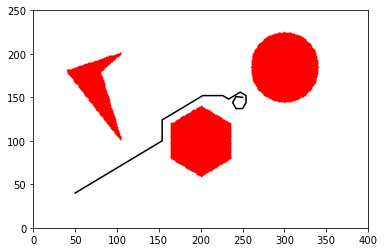

In [166]:
if __name__ == '__main__':
    main()